In [45]:
import sys
sys.path.append('../')
from common import *

import torch
import torch_dct as dct
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch.optim.lr_scheduler import StepLR

In [46]:
def bcirc(A):
    l, m, n = A.shape
    bcirc_A = []
    for i in range(l):
        bcirc_A.append(torch.roll(A, shifts=i, dims=0))
    return torch.cat(bcirc_A, dim=2).reshape(l*m, l*n)

def t_product(A, B):
    assert(A.shape[0] == B.shape[0] and A.shape[2] == B.shape[1])
    prod = torch.mm(bcirc(A), bcirc(B)[:, 0:B.shape[2]])
    return prod.reshape(A.shape[0], A.shape[1], B.shape[2])

def h_func_dct(lateral_slice):
    l, m, n = lateral_slice.shape
    dct_slice = dct.dct(lateral_slice)
    tubes = [dct_slice[i, :, 0] for i in range(l)]
    h_tubes = []
    for tube in tubes:
        tube_sum = torch.sum(torch.exp(tube))
        h_tubes.append(torch.exp(tube) / tube_sum)
    res_slice = torch.stack(h_tubes, dim=0).reshape(l, m, n)
    idct_a = dct.idct(res_slice)
    return torch.sum(idct_a, dim=0)

def scalar_tubal_func(output_tensor):
    l, m, n = output_tensor.shape
    lateral_slices = [output_tensor[:, :, i].reshape(l, m, 1) for i in range(n)]
    h_slice = []
    for slice in lateral_slices:
        h_slice.append(h_func_dct(slice))
    pro_matrix = torch.stack(h_slice, dim=2)
    return pro_matrix.reshape(m, n)

def raw_img(img, batch_size, n):
    img_raw = img.reshape(batch_size, n * n)
    single_img = torch.split(img_raw, split_size_or_sections=1, dim=0)
    single_img_T = [torch.transpose(i.reshape(n, n, 1), 0, 1) for i in single_img]
    ultra_img = torch.cat(single_img_T, dim=2)
    return ultra_img

In [47]:
class Transform_Layer(nn.Module):
    def __init__(self, size_in, size_out, n):
        super().__init__()
        self.size_in = size_in
        self.size_out = size_out
        weights = torch.randn(size_in, size_out, n)
        bias = torch.randn(size_in, size_out, 1)
        self.weights = nn.Parameter(weights, requires_grad=True)
        self.bias = nn.Parameter(bias, requires_grad=True)
        
    def forward(self, x):
        Wx = t_product(self.weights, x)
        return torch.add(Wx, self.bias)

In [48]:
class Transform_Net(nn.Module):
    def __init__(self):
        super(Transform_Net, self).__init__()
        self.features = nn.Sequential(
            Transform_Layer(28, 28, 28),
            nn.ReLU(inplace=True),
            Transform_Layer(28, 28, 28),
            nn.ReLU(inplace=True),
            Transform_Layer(28, 10, 28),
        )

    def forward(self, x):
        x.requires_grad = True
        x = self.features(x)        
        return x

In [49]:
def train_step_transform(epoch, train_acc, model, trainloader, optimizer):  
    device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
    model = model.to(device)
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    criterion = nn.CrossEntropyLoss()
    
    print('\nEpoch: ', epoch)
    print('|', end='')
    for batch_idx, (inputs, labels) in enumerate(trainloader):   
        inputs = raw_img(inputs, inputs.size(0), 28)
        inputs = inputs.to(device)
        labels = labels.to(device)
        # print(inputs.shape, labels.shape)
        
        outputs = model(inputs) / 1e4
        outputs = torch.transpose(scalar_tubal_func(outputs), 0, 1)
        
        optimizer.zero_grad()
        loss = criterion(outputs, labels)
        if np.isnan(loss.item()):
            print('Training terminated due to instability')
            break
        loss.backward()
        optimizer.step()
        train_loss += loss.item()  
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        if batch_idx % 10 == 0:
            print('=', end='')
    print('|', 'Accuracy:', correct / total, 'Loss:', train_loss / total)
    train_acc.append(correct / total)
    return train_acc

def test(test_acc, model, testloader):
    device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
    model = model.to(device)
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    criterion = nn.CrossEntropyLoss()
    s = time.time()
    with torch.no_grad():
        print('|', end='')
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs = raw_img(inputs, inputs.size(0), 28)
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs) / 1e4
            outputs = torch.transpose(scalar_tubal_func(outputs), 0, 1)
            loss = criterion(outputs, targets)
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            if batch_idx % 10 == 0:
                print('=', end='')
    e = time.time() 
    print('|', ' Test accuracy:', correct / total, 'Test loss:', test_loss / total)
    print('The inference time is', e - s, 'seconds')
    test_acc.append(correct / total)
    return test_acc, e - s
    
def train_transform(i, model, trainloader, testloader, optimizer):
    train_acc, test_acc = [], []
    scheduler = StepLR(optimizer, step_size=5, gamma=0.5)
    
    for epoch in range(i):
        s = time.time()
        train_acc = train_step_transform(epoch, train_acc, model, trainloader, optimizer)
        test_acc, _ = test(test_acc, model, testloader)
        scheduler.step()
        e = time.time()
        print('This epoch took', e - s, 'seconds to train')
        print('Current learning rate: ', scheduler.get_last_lr()[0])
    print('Best training accuracy overall: ', max(test_acc))
    return train_acc, test_acc

In [50]:
model = Transform_Net()
print(model)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
trainloader, testloader = load_mnist()

Transform_Net(
  (features): Sequential(
    (0): Transform_Layer()
    (1): ReLU(inplace=True)
    (2): Transform_Layer()
    (3): ReLU(inplace=True)
    (4): Transform_Layer()
  )
)
==> Loading data..


In [51]:
train_acc, test_acc = train_transform(25, model, trainloader, testloader, optimizer)


Epoch:  0
|============================================================| Accuracy: 0.7831166666666667 Loss: 0.007793634657810132
|==========|  Test accuracy: 0.8882 Test loss: 0.00420824014917016
The inference time is 49.25143122673035 seconds
This epoch took 1297.1691029071808 seconds to train
Current learning rate:  0.1

Epoch:  1
|============================================================| Accuracy: 0.9035 Loss: 0.0037918454128007093
|==========|  Test accuracy: 0.9196 Test loss: 0.0031752348717302083
The inference time is 49.3062846660614 seconds
This epoch took 1298.6940307617188 seconds to train
Current learning rate:  0.1

Epoch:  2
|============================================================| Accuracy: 0.9173 Loss: 0.00323115604793032
|==========|  Test accuracy: 0.9231 Test loss: 0.002999096132442355
The inference time is 48.45954704284668 seconds
This epoch took 1293.9626433849335 seconds to train
Current learning rate:  0.1

Epoch:  3
|===================================

In [63]:
def torch_tensor_Bcirc(tensor, l, m, n):
    tensor_blocks = list(torch.split(tensor, split_size_or_sections=1, dim=0))
    tensor_blocks.reverse()
    circ_slices, circ = [], []
    for i in range(l):
        tensor_blocks.insert(0, tensor_blocks.pop())
        for j in tensor_blocks:
            circ_slices.append(j.reshape(m, n))
    for i in range(l):
        circ.append(torch.cat(circ_slices[l * i:l * i + l], dim=1))
    ulti_circ = torch.cat(circ).reshape(l * m, l * n)
    return ulti_circ

def torch_tensor_product(tensorA, tensorB):
    a_l, a_m, a_n = tensorA.shape
    b_l, b_n, b_p = tensorB.shape
    assert(a_l == b_l and a_n == b_n)
    circA = torch_tensor_Bcirc(tensorA, a_l, a_m, a_n)
    circB = torch_tensor_Bcirc(tensorB, b_l, b_n, b_p)
    return torch.mm(circA, circB[:, 0:b_p]).reshape(a_l, a_m, b_p)

In [73]:
A = torch.rand(50, 50, 50).cuda()

In [74]:
%%time
for i in range(100):
    torch_tensor_product(A, A)

Wall time: 4.18 s


In [75]:
%%time
for i in range(100):
    t_product(A, A)

Wall time: 328 ms


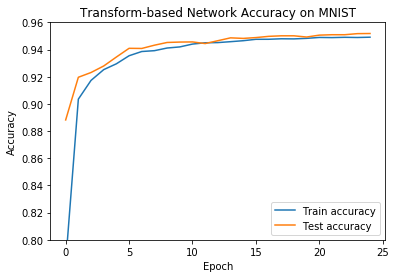

In [60]:
plt.plot(train_acc, label='Train accuracy')
plt.plot(test_acc, label='Test accuracy')
plt.ylim(0.8, 0.96)
plt.title('Transform-based Network Accuracy on MNIST')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()